# Stock price prediction using LSTM

In this example, stock prices are forecasted using LSTM cells. This is intended as an exercise to understand LSTM and its implementation using Tensorflow. The dataset consists of the prices of S&P 500 index and all the stocks that form the index, for 41266 minutes of data from April to August 2017 (downloaded from http://files.statworx.com/sp500.zip). 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Data preparation
The first part in implementing any machine learning algorithm is data preparation. This involes reading the data, cleaning it up, normalizing if necessary, and splitting it into train and test portions. In this example, the data is stored as a .csv file which is first read into a pandas dataframe object. The 'DATE' section of the data refers to the timestamp for each price, and this can be safely ignored as LSTM's do not use time as explicitly in the their computatation. 

In [2]:
# Import data
data = pd.read_csv('data_stocks.csv')

# Drop date variable
data = data.drop(['DATE'], 1)

# Know the shape of the data
print(" No. of rows is ",data.shape[0]," and no. of cols is ",data.shape[1])

 No. of rows is  41266  and no. of cols is  501


In [3]:
data.head()

,SP500,NASDAQ.AAL,NASDAQ.AAPL,NASDAQ.ADBE,NASDAQ.ADI,NASDAQ.ADP,NASDAQ.ADSK,NASDAQ.AKAM,NASDAQ.ALXN,NASDAQ.AMAT,...,NYSE.WYN,NYSE.XEC,NYSE.XEL,NYSE.XL,NYSE.XOM,NYSE.XRX,NYSE.XYL,NYSE.YUM,NYSE.ZBH,NYSE.ZTS
0,2363.6101,42.3300,143.6800,129.6300,82.040,102.2300,85.2200,59.760,121.52,38.99,...,84.370,119.035,44.40,39.88,82.03,7.36,50.22,63.86,122.000,53.350
1,2364.1001,42.3600,143.7000,130.3200,82.080,102.1400,85.6500,59.840,121.48,39.01,...,84.370,119.035,44.11,39.88,82.03,7.38,50.22,63.74,121.770,53.350
2,2362.6799,42.3100,143.6901,130.2250,82.030,102.2125,85.5100,59.795,121.93,38.91,...,84.585,119.260,44.09,39.98,82.02,7.36,50.12,63.75,121.700,53.365
3,2364.3101,42.3700,143.6400,130.0729,82.000,102.1400,85.4872,59.620,121.44,38.84,...,84.460,119.260,44.25,39.99,82.02,7.35,50.16,63.88,121.700,53.380
4,2364.8501,42.5378,143.6600,129.8800,82.035,102.0600,85.7001,59.620,121.60,38.93,...,84.470,119.610,44.11,39.96,82.03,7.36,50.20,63.91,121.695,53.240


As we can see, the dataset contains price history of S&P 500 as well as each of the 500 stocks that form the index. In this example, I will only try to use the SP500 price as the sequential data, as a simple start. Ofcourse one can even think of using the other stock prices to create a different problem. 

A good step in any data analysis is data visualization, done using matplotlib here. This helps us to understand the complexity of the data we are trying to model.

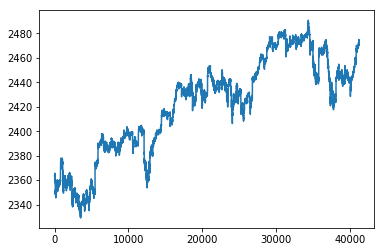

In [4]:
plt.plot(data['SP500'])
plt.show()

The data is rich of frequencies as is evident from the plot. Also, one can observe that the data has quite large values (mean around 2400). This can usually be problematic for machine learning algorithms , especially in the gradient descent step. Hence it is important to normalize the dataset, so that the values are sufficiently small. 

But before this step, we need to first formulate our problem, and decide what the inputs and the outputs are going to be. As a simple start, let us try to predict the next minute data from the previous ten minutes of data. This is a very standard problem in dynamical systems or stochastic systems where the state is estimated using the current and previous state. Another usual assumption in many stochastic systems is the Markovian property, which means that the current state alone contains all the information needed to estimate the next state. But here, we are using a sequence of previous states just as an example to implement LSTM. 

In [5]:
# Obtain the number of training samples and decide split factor for train-test split
nt = data.shape[0]
split = 0.8
ntrain = int(split*nt)
ntest = nt - ntrain
window = 10

# Only store the SP500 prices
data = data['SP500']
data = data.values

# Form the train and test input data
X_train = np.zeros((ntrain-window-1,window))
Y_train = np.zeros((ntrain-window-1,1))
X_test = np.zeros((ntest-window-1,window))
Y_test = np.zeros((ntest-window-1,1))
for i in range(ntrain-window-1):
    X_train[i,:] = data[i:i+window]
    Y_train[i,:] = data[i+window]

# Form train and test output data    
for i in range(ntest-window-1):
    X_test[i,:] = data[i+ntrain:i+ntrain+window]
    Y_test[i,:] = data[i+ntrain+window]    

In [6]:
# Just see the new training and test size
print(X_train.shape,Y_train.shape,X_test.shape,Y_test.shape)

(33001, 10) (33001, 1) (8243, 10) (8243, 1)


Now that we have the input and output data nicely divided as test and train, we can proceed to apply normalization.

In [7]:
# normalize the training and use this parameters to normalize test
from sklearn.preprocessing import StandardScaler
Normalize = StandardScaler()

# Fit transform on training
X_train = Normalize.fit_transform(X_train)
Y_train = Normalize.fit_transform(Y_train)

# Transform on test
X_test = Normalize.transform(X_test)
Y_test = Normalize.transform(Y_test)

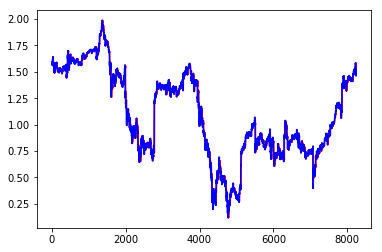

In [8]:
# Jut plot the test and trainng tests to see if the normalization has been properly implemented.
plt.plot(X_test[:,0],'r',Y_test[:,0],'b')
plt.show()

In [10]:
# This reshaping is required for Tensorflow, 
# which needs the input to be (number of samples, length of sequence, number of features)
ntrain = X_train.shape[0]
ntest = X_test.shape[0]

X_train_shaped = np.zeros((ntrain,window,1))
X_test_shaped = np.zeros((ntest,window,1))
X_train_shaped[:,:,0] = X_train[:,:]
X_test_shaped[:,:,0] = X_test[:,:]

# Tensorflow computational graph
The next step is the implementation of LSTM using Tensorflow API. We will use the tf.nn.rnn_cell.LSTMCell function to create a single LSTM cell. I strongly advise you to check out other cells and read about them. Here we will only use a single layer of LSTM cell, followed by a linear transformation of the output. But ofcourse one can add multiple layers and this is another hyperparameter in the implementation of neural networks. 

The num_hidden layer required for the LSTMCell is a quite tricky parameter. It does not represent the number of hidden layers, but the size of the output of the LSTM cell. The key idea is to map an input to a higher dimensional cell output, and then look for relationships in this cell output space, followed by a transformation (i.e. weights*output + bias) to the actual output (referred as target). This is similar to the Kernel ideas, if you are familiar with it. 

Briefly speaking, tensorflow creates a computational graph, which is evaluated only when sess.run() is called. For recurrent neural nets, the network has to be unrolled to create the computational graph, which is achieved by using tf.nn.dynamic_rnn(). The output of the unrolled network is a sequence of outputs, with the length of sequence equal to the length of the input, and the size of each element of the sequence equal to the num_hidden parameter.

The last steps are creating a loss function, and mean square error seems to be a good indicator of the loss. The optimization can be solved using different algorithms, and here I have used AdamOptimizer.

In [11]:
# Placeholders for input (data) and output(target)
data = tf.placeholder(tf.float32, [None, window,1])
target = tf.placeholder(tf.float32, [None, 1])

# Specify the number of hidden cells and create one LSTM cell
num_hidden = 24
cell = tf.nn.rnn_cell.LSTMCell(num_hidden)

# Unroll the cell using dynamic_rnn
val, state = tf.nn.dynamic_rnn(cell, data, dtype=tf.float32)

val = tf.transpose(val, [1, 0, 2])
last = tf.gather(val, int(val.get_shape()[0]) - 1)

weight = tf.Variable(tf.truncated_normal([num_hidden, int(target.get_shape()[1])]))
bias = tf.Variable(tf.constant(0.1, shape=[target.get_shape()[1]]))

prediction = tf.matmul(last, weight) + bias
cross_entropy = tf.losses.mean_squared_error(prediction,target)

optimizer = tf.train.AdamOptimizer()
minimize = optimizer.minimize(cross_entropy)

/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


After creating the computational graph, the input and output is fed as a dictionary using feed_dict parameter in a batch fashion. I have been using this template for implementing neural networks in a rather quick manner, and also in a more clean and intuitive ways (rather than use lot of unnecassary functions and classes).

In [12]:
init_op = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init_op)

batch_size = 1000
no_of_batches = int(ntrain/batch_size)
epoch = 100
for i in range(epoch):
    ptr = 0
    for j in range(no_of_batches):
        inp, out = X_train_shaped[ptr:ptr+batch_size,:,:], Y_train[ptr:ptr+batch_size,:]
        ptr+=batch_size
        loss,_ = sess.run([cross_entropy,minimize],feed_dict={data: inp, target: out})
    if(i%50 == 0):
        print("Epoch - ",str(i)," loss - ",loss)
test_loss,Y_pred = sess.run([cross_entropy,prediction],feed_dict={data:X_test_shaped, target: Y_test})
print('Test loss -',test_loss)
sess.close()

Epoch -  0  loss -  0.536583
Epoch -  50  loss -  0.000792924
Test loss - 0.000609993


Voila, the loss for the test set is very low which means that LSTM is very efficient in predicting the next minute of stock data. Note that the variables you want to print on screen or use later must be included in the sess.run() input as a list. Otherwise they will be computed but not accesible!

Don't be very happy, as this is not useful in practical scenaries, where one might be interesting in predicting prices in a bit larger timestep and modelling trends over larger time periods, rather than just a minute ahead. But this is intended as toy problem to learn implmentation of LSTM in tensorflow.

Let us go ahead and compare the predictions with the actual test data.

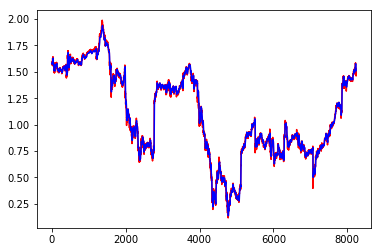

In [13]:
plt.plot(Y_test,'r',Y_pred,'b')
plt.show()